Dynamic ensemble selection is an ensemble learning technique that automatically selects a subset of ensemble members just-in-time when making a prediction.

The technique involves fitting multiple machine learning models on the training dataset, then selecting the models that are expected to perform best when making a prediction for a specific new example, based on the details of the example to be predicted.

This can be achieved using a k-nearest neighbor model to locate examples in the training dataset that are closest to the new example to be predicted, evaluating all models in the pool on this neighborhood and using the models that perform the best on the neighborhood to make a prediction for the new example.

# Dynamic Ensemble Selection

Dynamic Classifier Selection: Algorithms that dynamically choose one from among many trained models to make a prediction based on the specific details of the input.

Dynamic Classifier Selection algorithms generally involve partitioning the input feature space in some way and assigning specific models to be responsible for making predictions for each partition.

Dynamic Ensemble Selection: Algorithms that dynamically choose a subset of trained models to make a prediction based on the specific details of the input.

Dynamic Ensemble Selection algorithms operate much like DCS algorithms, except predictions are made using votes from multiple classifier models instead of a single best model. In effect, each region of the input feature space is owned by a subset of models that perform best in that region.

## Dynamic Classifier Selection Local Accuracy

DCS-LA involves selecting the k-nearest neighbors from the training or validation dataset for a given new input pattern, then selecting the single best classifier based on its performance in that neighborhood of k examples to make a prediction on the new example.

## k-Nearest Neighbor Oracle

KNORA was described by Albert Ko, et al. in their 2008 paper titled “From Dynamic Classifier Selection To Dynamic Ensemble Selection.” It is an extension of DCS-LA that selects multiple models that perform well on the neighborhood and whose predictions are then combined using majority voting to make a final output prediction.

The ensemble is considered dynamic because the members are chosen just-in-time conditional on the specific input pattern requiring a prediction. This is opposed to static, where ensemble members are chosen once, such as averaging predictions from all classifiers in the model.

Two versions of KNORA are described, including KNORA-Eliminate and KNORA-Union.

    KNORA-Eliminate (KNORA-E): Ensemble of classifiers that achieves perfect accuracy on the neighborhood of the new example, with a reducing neighborhood size until at least one perfect classifier is located.
    
    KNORA-Union (KNORA-U): Ensemble of all classifiers that makes at least one correct prediction on the neighborhood with weighted voting and votes proportional to accuracy on the neighborhood.


KNORA-Eliminate, or KNORA-E for short, involves selecting all classifiers that achieve perfect predictions on the neighborhood of k examples in the neighborhood. If no classifier achieves 100 percent accuracy, the neighborhood size is reduced by one and the models are re-evaluated. This process is repeated until one or more models are discovered that has perfect performance, and then used to make a prediction for the new example.

KNORA-Union, or KNORA-U for short, involves selecting all classifiers that make at least one correct prediction in the neighborhood. The predictions from each classifier are then combined using a weighted average, where the number of correct predictions in the neighborhood indicates the number of votes assigned to each classifier.

# k-Nearest Neighbor Oracle (KNORA)

## KNORA-Eliminate (KNORA-E)

In this case, we will use default model hyperparameters, including bagged decision trees as the pool of classifier models and a k=7 for the selection of the local neighborhood when making a prediction.

We will evaluate the model using repeated stratified k-fold cross-validation with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

In [45]:
# evaluate dynamic KNORA-E dynamic ensemble selection for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from matplotlib import pyplot

In [23]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import model
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

In [3]:
# define the model
model = KNORAE()

In [4]:
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [5]:
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.913 (0.008)


We can also use the KNORA-E ensemble as a final model and make predictions for classification.

In [7]:
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
row = [0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]
yhat = model.predict([row])
print('Predicted Class: %d' % yhat[0])

Predicted Class: 0


## KNORA-Union (KNORA-U)

In [9]:
# define the model
model = KNORAU()

In [10]:
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [11]:
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.937 (0.008)


In [12]:
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
row = [0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]
yhat = model.predict([row])
print('Predicted Class: %d' % yhat[0])

Predicted Class: 0


## Hyperparameter Tuning for KNORA

There are many hyperparameters we can look at for KNORA, although in this case, we will look at the value of k in the k-nearest neighbor model used in the local evaluation of the models, and how to use a custom pool of classifiers.

### Explore k in k-Nearest Neighbors

The configuration of the k-nearest neighbors algorithm is critical to the KNORA model as it defines the scope of the neighborhood in which each ensemble is considered for selection.

The k value controls the size of the neighborhood and it is important to set it to a value that is appropriate for your dataset, specifically the density of samples in the feature space. A value too small will mean that relevant examples in the training set might be excluded from the neighborhood, whereas values too large may mean that the signal is being washed out by too many examples.

In [20]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y

In [21]:
X, y = get_dataset()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=None)

evaluate knorau predictions at accuracy
> k at 2 | mean = 0.934 | std = 0.010
> k at 3 | mean = 0.935 | std = 0.010
> k at 4 | mean = 0.934 | std = 0.009
> k at 5 | mean = 0.934 | std = 0.010
> k at 6 | mean = 0.936 | std = 0.009
> k at 7 | mean = 0.934 | std = 0.010
> k at 8 | mean = 0.933 | std = 0.011
> k at 9 | mean = 0.935 | std = 0.009
> k at 10 | mean = 0.933 | std = 0.009
> k at 11 | mean = 0.934 | std = 0.008
> k at 12 | mean = 0.934 | std = 0.011
> k at 13 | mean = 0.934 | std = 0.008
> k at 14 | mean = 0.935 | std = 0.008
> k at 15 | mean = 0.935 | std = 0.007
> k at 16 | mean = 0.933 | std = 0.008
> k at 17 | mean = 0.936 | std = 0.008
> k at 18 | mean = 0.933 | std = 0.008
> k at 19 | mean = 0.936 | std = 0.007
> k at 20 | mean = 0.935 | std = 0.008
> k at 21 | mean = 0.935 | std = 0.009


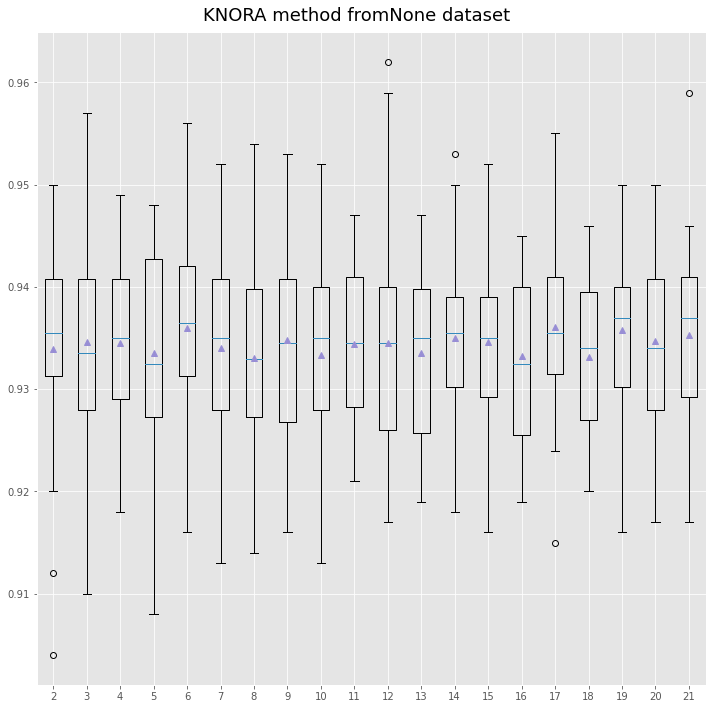

In [42]:
model.dse(X,y,X_test=None,y_test=None,action='k',types='knorau',k_value=22,scoring='accuracy',title=None,footnote=None)

In [56]:
y_pred,y_proba = model.dse(X_train, y_train, X_test, y_test,
                           action='final',types='knorau',k_value=10,
                           scoring='accuracy',title=None,footnote=None)

evaluate knorau predictions
> Accuracy model knorau: 0.895
evaluate contributing models
> Accuracy model LogisticRegression: 0.873
> Accuracy model DecisionTreeClassifier: 0.886
